In this notebook different quantisation methods and distance metrics for Facial Recognition will be compared both on accuracy and execution time. 

The Quantisation methods include:
- Scalar Quantisation
- TensorFlow Quantisation

The distance metrics include:
- Cosine Similarity
- Euclidean Distance

Below are the necassary import to run the code.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # suppress tensorflow warnings https://stackoverflow.com/a/40871012
from deepface import DeepFace
import subprocess
import numpy as np
from decimal import Decimal # for proper rounding
import random
import time
import pandas as pd
from datetime import datetime
import struct
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import statistics
import accuracy as ac
import pickle
import quantisations as qt


import basics as bs


# CONSTANTS
EXECUTABLE_PATH = "ABY/build/bin"
INPUT_FILE_NAME = "input_vecs.txt"
EXECUTABLE_NAME_SCENARIO = 'cos_dist_copy'
CMD_SCENARIO = f"./{EXECUTABLE_NAME_SCENARIO} -r 1 -f {INPUT_FILE_NAME} & (./{EXECUTABLE_NAME_SCENARIO} -r 0 -f {INPUT_FILE_NAME} 2>&1 > /dev/null)"

# random number generator
rng = np.random.default_rng()

Below are two functions to compare Facenet and Sface accuracy. One for Euclidean Distance and one for Cosine Similarity. The code to create a visual representation for this comparison is also included.

In [2]:
###### GENERATING THE GLOBAL PAIRS. 
######## we only need to run this once and then we can have the file and use pairs as the list of embeddings 
########## uncomment to use for first them, then use the next cell!

##########!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!##########
## IF U GENERATE A NEW FILE, CHANGE THE NAME!!!! THE EMBEDINGPAIRS.PKL IS THE WORKING ONE AND THE ONE USED!!!!!!!!!!!!!!!!!!!##########
##########!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!##########

# #
# # Generate pairs globally
def generate_pairs(m):
    pairs = []
    for _ in range(m):
        n = random.choice([True, False])
        imga, imgb = bs.get_two_random_images(same_person=n)
        pairs.append((imga, imgb,n))
    return pairs

# m = 2000
# pairs = generate_pairs(m)

#File path
file_path = 'embedingpairs.pkl'

# # Delete the file if it exists
# if os.path.exists(file_path):
#     os.remove(file_path)

# # Save pairs to a new file
# with open(file_path, 'wb') as file:
#     pickle.dump(pairs, file)

In [3]:
with open(file_path, 'rb') as file:
    pairs = pickle.load(file)

In [4]:
# Running the comparison functions

counters_euc,times_euc = ac.compare_accuracies_euc(pairs)


In [5]:
counters_cos,times_cos = ac.compare_accuracies_cos(pairs)

In [6]:
counters_euc

{'scalar_quantisation_max': {'correct_tensor_facenet': 554,
  'wrong_tensor_facenet': 446,
  'correct_scalar_facenet': 554,
  'wrong_scalar_facenet': 446,
  'correct_noquant_facenet': 768,
  'wrong_noquant_facenet': 232,
  'correct_tensor_sface': 555,
  'wrong_tensor_sface': 445,
  'correct_scalar_sface': 555,
  'wrong_scalar_sface': 445,
  'correct_noquant_sface': 841,
  'wrong_noquant_sface': 159},
 'scalar_quantisation_percentile': {'correct_tensor_facenet': 554,
  'wrong_tensor_facenet': 446,
  'correct_scalar_facenet': 554,
  'wrong_scalar_facenet': 446,
  'correct_noquant_facenet': 768,
  'wrong_noquant_facenet': 232,
  'correct_tensor_sface': 555,
  'wrong_tensor_sface': 445,
  'correct_scalar_sface': 555,
  'wrong_scalar_sface': 445,
  'correct_noquant_sface': 841,
  'wrong_noquant_sface': 159}}

In [7]:
counters_cos

{'scalar_quantisation_max': {'correct_tensor_facenet': 458,
  'wrong_tensor_facenet': 542,
  'correct_scalar_facenet': 458,
  'wrong_scalar_facenet': 542,
  'correct_noquant_facenet': 839,
  'wrong_noquant_facenet': 161,
  'correct_tensor_sface': 458,
  'wrong_tensor_sface': 542,
  'correct_scalar_sface': 458,
  'wrong_scalar_sface': 542,
  'correct_noquant_sface': 834,
  'wrong_noquant_sface': 166},
 'scalar_quantisation_percentile': {'correct_tensor_facenet': 458,
  'wrong_tensor_facenet': 542,
  'correct_scalar_facenet': 827,
  'wrong_scalar_facenet': 173,
  'correct_noquant_facenet': 839,
  'wrong_noquant_facenet': 161,
  'correct_tensor_sface': 458,
  'wrong_tensor_sface': 542,
  'correct_scalar_sface': 818,
  'wrong_scalar_sface': 182,
  'correct_noquant_sface': 834,
  'wrong_noquant_sface': 166}}

In [8]:
def calculate_confidence_intervals(counters, total_trials, confidence_level=0.95):
    z = 1.96  # z-score for 95% confidence
    intervals = {}

    for name, counts in counters.items():
        intervals[name] = {}
        for key, count in counts.items():
            p = count / total_trials
            margin_error = z * np.sqrt(p * (1 - p) / total_trials)
            lower_bound = p - margin_error
            upper_bound = p + margin_error
            intervals[name][key] = (lower_bound, upper_bound)

    return intervals

In [9]:
total_trials = 1000  # if you're running m=1000 trials

In [11]:
intervals = calculate_confidence_intervals(times_cos, total_trials)
print(intervals)

{'scalar_quantisation_max': {'tensor_time': (-0.0009520492940775656, 0.0032190609365336203), 'scalar_time': (-0.0006791485594364718, 0.0010837034033390597), 'noquant_time': (0.0, 0.0)}, 'scalar_quantisation_percentile': {'tensor_time': (-0.0009520492940775656, 0.0032190609365336203), 'scalar_time': (-0.0009334139643898337, 0.0035316791354408593), 'noquant_time': (0.0, 0.0)}}


In [12]:
intervals2 = calculate_confidence_intervals(times_euc, total_trials)
print(intervals2)

{'scalar_quantisation_max': {'tensor_time': (-0.0006477882781622583, 0.005365953198969143), 'scalar_time': (-0.0007495077584861523, 0.001292224738466621), 'noquant_time': (0.0, 0.0)}, 'scalar_quantisation_percentile': {'tensor_time': (-0.0006477882781622583, 0.005365953198969143), 'scalar_time': (-0.0009143144429136578, 0.0037502514660764995), 'noquant_time': (0.0, 0.0)}}


In [12]:
m=1000
# Calculate and print the average execution times
print("Average Execution Times (in seconds):")
for name in times_euc.keys():
    avg_tensor_time_euc = times_euc[name]['tensor_time'] / m  # Assuming m=1000
    avg_scalar_time_euc = times_euc[name]['scalar_time'] / m
    
    avg_tensor_time_cos = times_cos[name]['tensor_time'] / m
    avg_scalar_time_cos = times_cos[name]['scalar_time'] / m

    print(f"\nQuantization Method: {name}")
    # print(f"  Total Tensor Time (Euclidean): {times_euc[name]['tensor_time']} seconds")
    # print(f"  Total Scalar Time (Euclidean): {times_euc[name]['scalar_time']} seconds")
    print(f"  Average Tensor Time (Euclidean): {avg_tensor_time_euc:.6f} seconds")
    print(f"  Average Scalar Time (Euclidean): {avg_scalar_time_euc:.6f} seconds")
    
    # print(f"  Total Tensor Time (Cosine): {times_cos[name]['tensor_time']} seconds")
    # print(f"  Total Scalar Time (Cosine): {times_cos[name]['scalar_time']} seconds")
    print(f"  Average Tensor Time (Cosine): {avg_tensor_time_cos:.6f} seconds")
    print(f"  Average Scalar Time (Cosine): {avg_scalar_time_cos:.6f} seconds")


Average Execution Times (in seconds):

Quantization Method: scalar_quantisation_max
  Average Tensor Time (Euclidean): 0.001941 seconds
  Average Scalar Time (Euclidean): 0.000211 seconds
  Average Tensor Time (Cosine): 0.001011 seconds
  Average Scalar Time (Cosine): 0.000184 seconds

Quantization Method: scalar_quantisation_percentile
  Average Tensor Time (Euclidean): 0.001941 seconds
  Average Scalar Time (Euclidean): 0.001141 seconds
  Average Tensor Time (Cosine): 0.001011 seconds
  Average Scalar Time (Cosine): 0.001177 seconds


below will be the functions to compare the execution time of (Facenet, SFace) x (Euclidean, Cosine) X (no quantisation, Tensorflow, scalar)

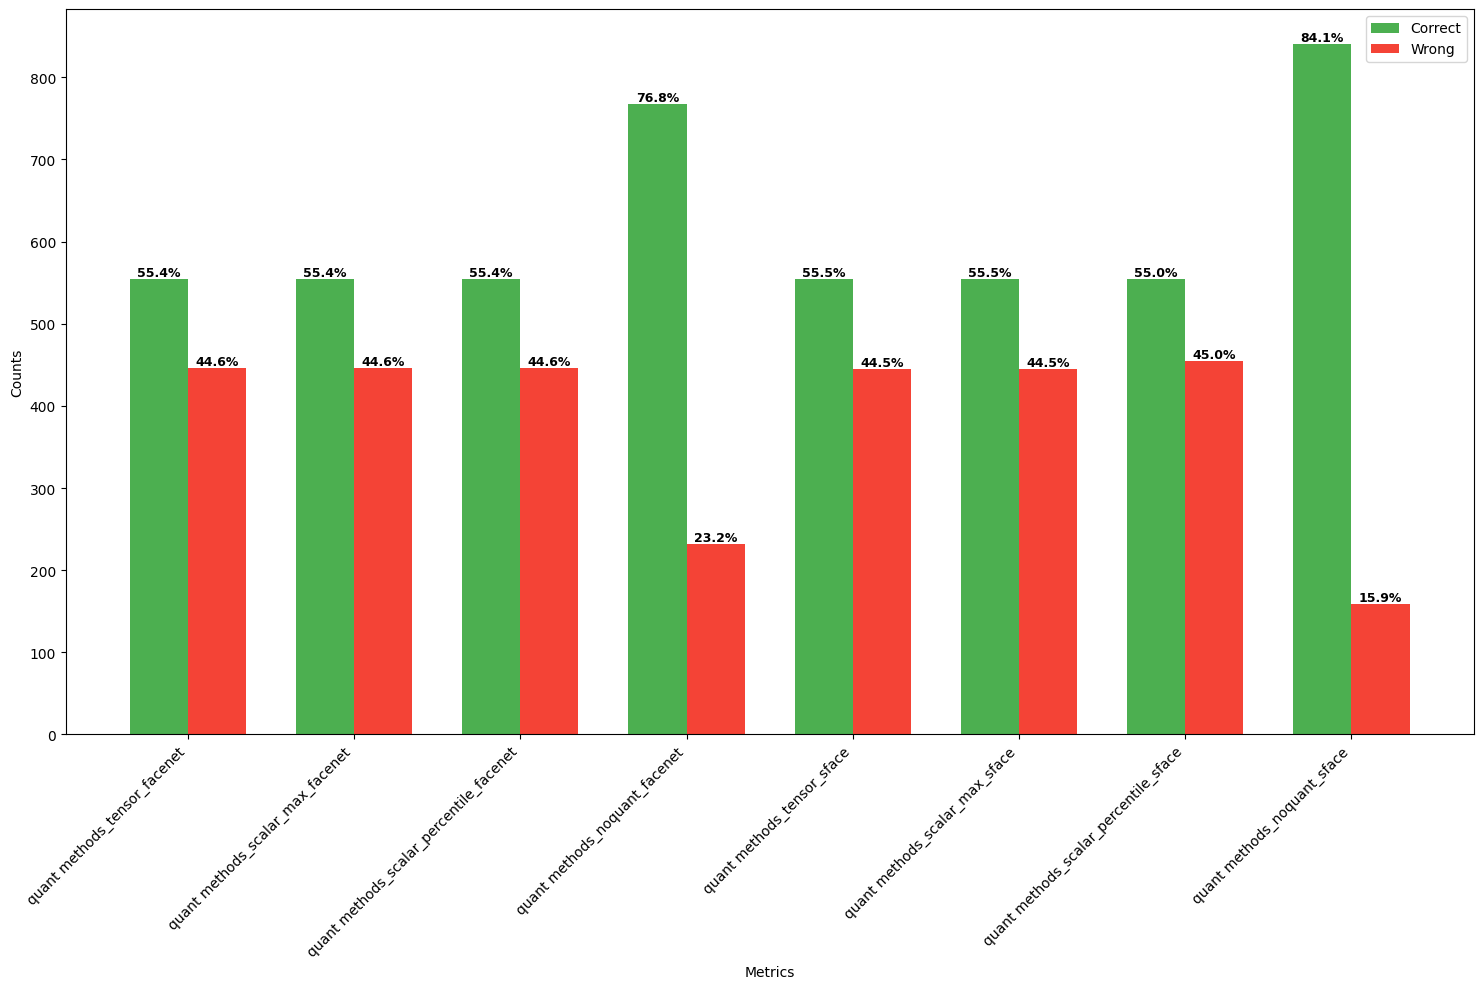

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Provided data
data = {'quant methods':{'correct_tensor_facenet': 554,
  'wrong_tensor_facenet': 446,
  'correct_scalar_max_facenet': 554,
  'wrong_scalar_max_facenet': 446,
  'correct_noquant_facenet': 768,
  'wrong_noquant_facenet': 232,
  'correct_tensor_sface': 555,
  'wrong_tensor_sface': 445,
  'correct_scalar_max_sface': 555,
  'wrong_scalar_max_sface': 445,
  'correct_noquant_sface': 841,
  'wrong_noquant_sface': 159,
  'correct_scalar_percentile_facenet': 554,
  'wrong_scalar_percentile_facenet': 446,
  'correct_scalar_percentile_sface': 555,
  'wrong_scalar_percentile_sface': 455},}

# Extract categories and metrics
categories = list(data.keys())
metrics = ['tensor_facenet', 'scalar_max_facenet',  'scalar_percentile_facenet', 'noquant_facenet', 'tensor_sface', 'scalar_max_sface', 'scalar_percentile_sface', 'noquant_sface']

# Initialize lists to hold the bar heights and percentages
correct_counts = []
wrong_counts = []
correct_percentages = []
wrong_percentages = []

# Calculate counts and percentages for each metric in each category
for metric in metrics:
    for category in categories:
        correct = data[category][f'correct_{metric}']
        wrong = data[category][f'wrong_{metric}']
        total = correct + wrong
        correct_percentage = (correct / total) * 100
        wrong_percentage = (wrong / total) * 100
        
        correct_counts.append(correct)
        wrong_counts.append(wrong)
        correct_percentages.append(correct_percentage)
        wrong_percentages.append(wrong_percentage)

# Plotting
fig, ax = plt.subplots(figsize=(15, 10))
bar_width = 0.35
index = np.arange(len(metrics) * len(categories))

# Plot bars for correct and wrong counts
bars_correct = ax.bar(index, correct_counts, bar_width, label='Correct', color='#4CAF50')
bars_wrong = ax.bar(index + bar_width, wrong_counts, bar_width, label='Wrong', color='#F44336')

# Annotate bars with percentages
for bars, percentages, align in zip([bars_correct, bars_wrong], [correct_percentages, wrong_percentages], ['center', 'center']):
    for bar, percentage in zip(bars, percentages):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.1f}%', ha=align, va='bottom', fontsize=9, color='black', weight='bold')

# Customizing the plot
ax.set_xlabel('Metrics')
ax.set_ylabel('Counts')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels([f'{category}_{metric}' for metric in metrics for category in categories], rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

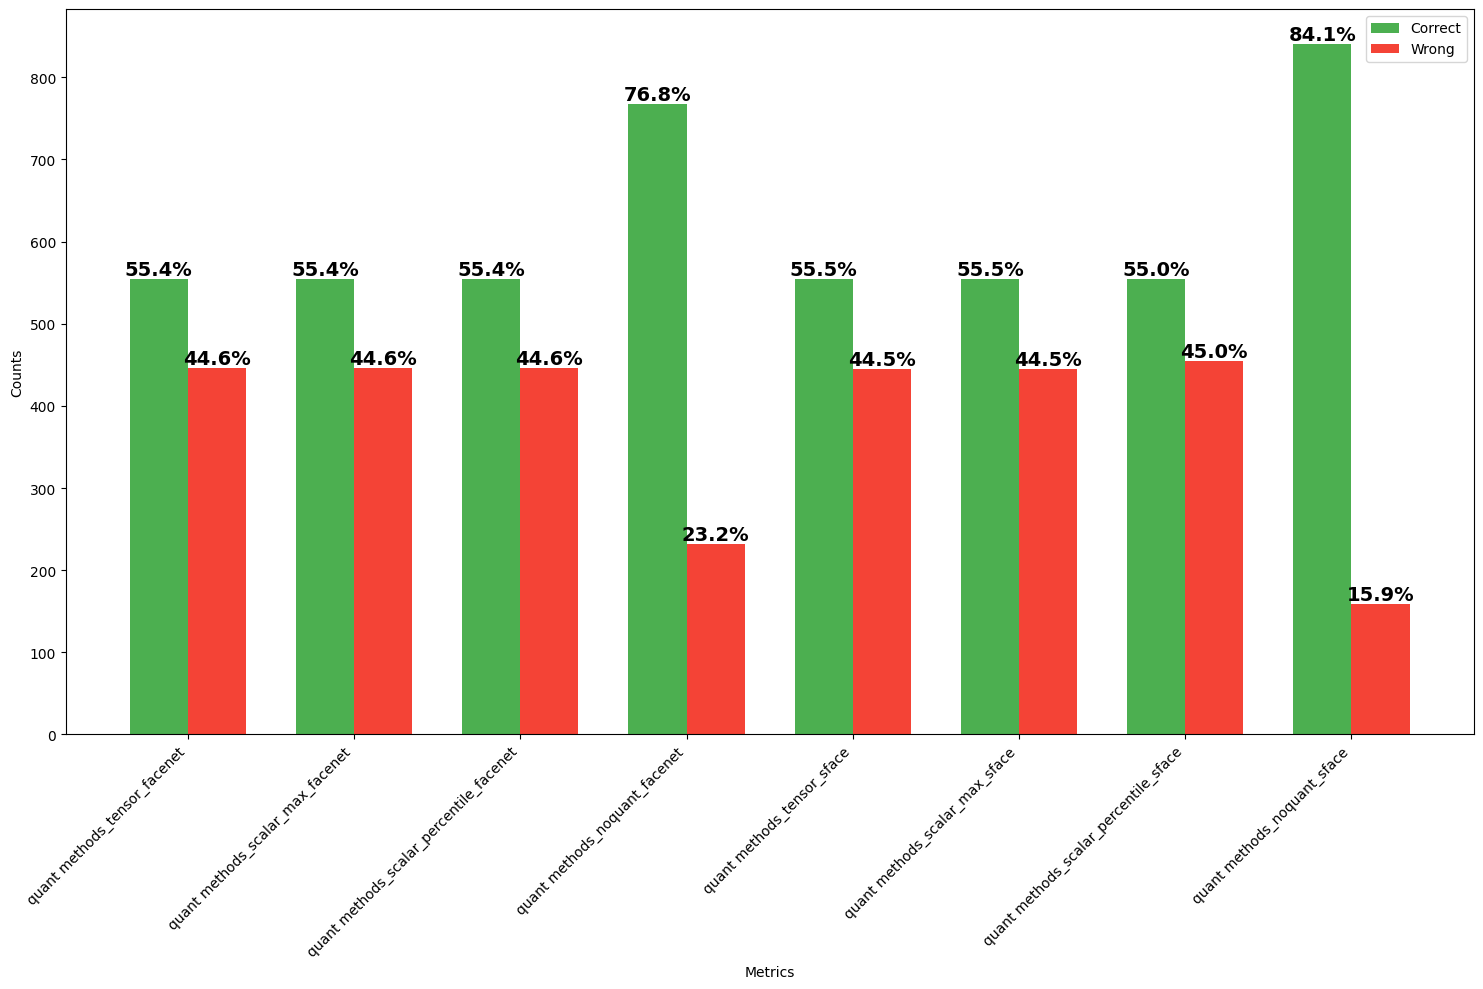

In [16]:
# Extract categories and metrics
categories = list(data.keys())
metrics = ['tensor_facenet', 'scalar_max_facenet', 'scalar_percentile_facenet', 'noquant_facenet', 'tensor_sface', 'scalar_max_sface', 'scalar_percentile_sface', 'noquant_sface']

# Initialize lists to hold the bar heights and percentages
correct_counts = []
wrong_counts = []
correct_percentages = []
wrong_percentages = []

# Calculate counts and percentages for each metric in each category
for metric in metrics:
    for category in categories:
        correct = data[category][f'correct_{metric}']
        wrong = data[category][f'wrong_{metric}']
        total = correct + wrong
        correct_percentage = (correct / total) * 100
        wrong_percentage = (wrong / total) * 100
        
        correct_counts.append(correct)
        wrong_counts.append(wrong)
        correct_percentages.append(correct_percentage)
        wrong_percentages.append(wrong_percentage)

# Plotting
fig, ax = plt.subplots(figsize=(15, 10))
bar_width = 0.35
index = np.arange(len(metrics) * len(categories))

# Plot bars for correct and wrong counts
bars_correct = ax.bar(index, correct_counts, bar_width, label='Correct', color='#4CAF50')
bars_wrong = ax.bar(index + bar_width, wrong_counts, bar_width, label='Wrong', color='#F44336')

# Annotate bars with percentages
for bars, percentages, align in zip([bars_correct, bars_wrong], [correct_percentages, wrong_percentages], ['center', 'center']):
    for bar, percentage in zip(bars, percentages):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.1f}%', ha=align, va='bottom', fontsize=14, color='black', weight='bold')

# Customizing the plot
ax.set_xlabel('Metrics')
ax.set_ylabel('Counts')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels([f'{category}_{metric}' for metric in metrics for category in categories], rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


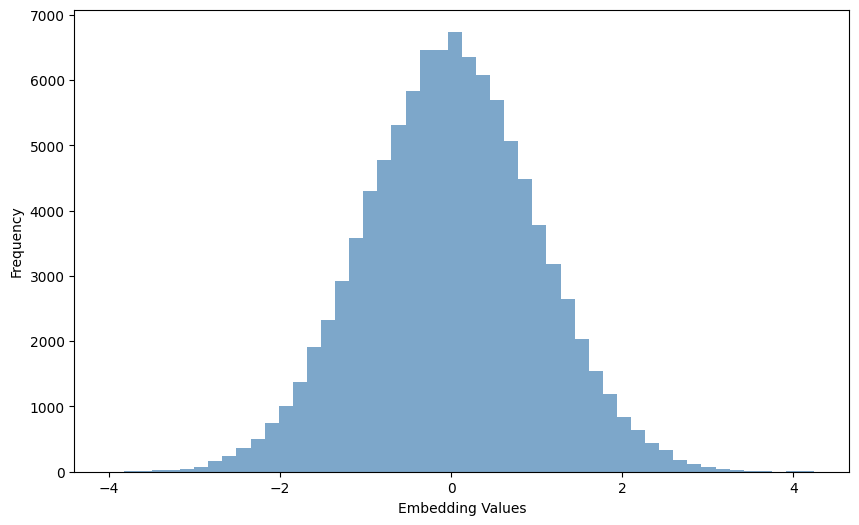

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data - replace this with your actual data
data = np.random.normal(0, 1, 100000)  # Example data, normally distributed

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(data, bins=50, color='steelblue', alpha=0.7)

# Remove the title
# plt.title('Histogram of Face Embedding Values')  # This line is removed

# Set the labels for x and y axes
plt.xlabel('Embedding Values')
plt.ylabel('Frequency')

# Show the plot
plt.show()
